In [1]:
%matplotlib inline
import  matplotlib
import matplotlib.pyplot as plt
import pystan

In [2]:
import numpy as np

In [3]:
import scipy.io as sio

In [4]:
df = sio.loadmat('snelson1d.mat')

In [5]:
X = df['X']
Y = df['Y']
X_t = df['tX']
Y_t = df['tY']

In [6]:
M = 20
X_u= np.linspace(0,6, M)[:, None]
X_u_noisy = X_u + 0.1*np.random.rand(*X_u.shape) 

### Code

In [2]:
stan_code_fitc ="""

functions{
    vector gp_pred_rng(real[] x_star, vector y, real[] x_train, real[] xu, real alpha, real rho, real sigma, real jitter){
        
        int N1 = rows(y);
        int N2 = size(x_star);
        int M = size(xu);
        
        vector[N2] f2;
        {
            matrix[N1, N1] Kff = cov_exp_quad(x_train, alpha, rho);
            matrix[N1, M] Kfu = cov_exp_quad(x_train, xu, alpha, rho);
            matrix[N2, N2] K_star_star = cov_exp_quad(x_star, alpha, rho);
            matrix[M, M] Kuu = cov_exp_quad(xu, alpha, rho);
            
            matrix[N1, N1] L_K= cholesky_decompose(Kff);
            matrix[M, M] L_U = cholesky_decompose(Kuu);
            
        
        
        }
    
    
    
    }

}

data {
    int<lower=1> N;
    int<lower=1> M;
    int<lower=1> N_star;
    real x[N];
    real x_star[N_star];
    vector[N] y;
    real xu[M];

}
transformed data {
    real delta = 1e-6;
#     real rho = 1;
#     real alpha = 1;

}
parameters {
    vector[N] f;
    
    real<lower=1e-6> sigma;
    real <lower=1e-4> alpha;
    real<lower=1e-4> rho;
    
    vector[M] eta;
}

model {

    vector[N] f_mean;
    matrix[N, N] f_cov;
    matrix[N, N] A;
    matrix[N, N] diff;
        
    {
        matrix[M, M] L_U;
        matrix[M, M] Kuu = cov_exp_quad(xu, alpha, rho);
        matrix[N, M] Kfu = cov_exp_quad(x, xu, alpha, rho);
        matrix[N, N] K = cov_exp_quad(x, alpha, rho);
        vector[M] Kuu_inv_u;
        matrix[M, N] v_pred;
        vector[M] u;
        
        for (m in 1:M)
            Kuu[m, m] = Kuu[m, m] + delta;
                    
        L_U = cholesky_decompose(Kuu);
        u = L_U * eta2;
        
        // f_mean = Kfu*(Kuu_inv*u) = Kfu * inv(LL')u = Kfu * inv(L') *inv(L) * L * eta = = Kfu * inv(L') * eta;        
#         Kuu_inv_u = mdivide_left_tri_low(L_U', eta);
        
        Kuu_inv_u = mdivide_right_tri_low(eta', L_U)';
        f_mean = Kfu*Kuu_inv_u;
        

        // f_cov = K - Kfu*(Kuu_inv*Kfu');            
        v_pred = mdivide_left_tri_low(L_U, Kfu');
        diff = K - v_pred'*v_pred;
        for (i in 1:N){
            for(j in 1:N){
                A[i,j] = 0.0;
            }
            A[i,i] = diff[i,i];
        }
    }
  
    
    rho ~ normal(0.90, 0.25);
    alpha ~ normal(0.85, 0.25);

    sigma ~ normal(0, 0.35);
    eta ~ normal(0, 1);
    f ~ multi_normal(f_mean, A);
    y ~ normal(f, sigma);
}

generated quantities{
    vector[N_star] f_star = gp_pred_rng(x_star, y, x, alpha, rho, sigma, jitter); 
    vector[N_star] y_star = normal_rng(f_star, sigma);
    vector[N_star] y_star;
    for (i in 1:N_star){
        y_star[i] = normal_rng(f_star[i], sigma);
    }
    
}

"""


In [3]:
stan_model_fitc_cond = pystan.StanModel(model_code=stan_code_fitc)

NameError: name 'pystan' is not defined

In [36]:
gp_reg_data = {'N':200, 'x':X.flatten(), 'y':Y.flatten(), 'M':20, 'xu':X_u_noisy.flatten()}

In [47]:
fit_fitc = stan_model_fitc.sampling(data=gp_reg_data, iter=1400, chains=4)

/u/26/dhakaa1/unix/anaconda2/envs/stanpy35/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [16]:
print(fit_fitc)

Inference for Stan model: anon_model_12e14653aa29f09b4da7ec559b662fe4.
2 chains, each with iter=600; warmup=300; thin=1; 
post-warmup draws per chain=300, total post-warmup draws=600.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
f[0]     8.2e-3    0.03   0.06  -0.11-7.7e-3 4.4e-4   0.01   0.17      5   2.02
f[1]      -0.27    0.01   0.03  -0.32  -0.28  -0.26  -0.25  -0.22      4   2.41
f[2]       0.05    0.12   0.12   -0.1  -0.08   0.09   0.16   0.17      1   7.79
f[3]       0.07    0.04   0.04   0.02   0.03   0.08    0.1    0.1      1   6.05
f[4]       0.02    0.02   0.04  -0.08 7.6e-3   0.04   0.04   0.08      5   1.51
f[5]       0.22     0.1    0.1   0.12   0.13   0.19   0.32   0.35      1   7.35
f[6]       0.06  9.9e-3   0.01   0.03   0.05   0.07   0.07   0.08      2   1.45
f[7]       -0.2     0.1    0.1   -0.3  -0.29  -0.27  -0.09  -0.03      1   3.02
f[8]       0.05    0.04   0.04-5.6e-3 7.7e-3   0.05   0.09    0.1      1   6.94
f[9]       0.04

In [17]:
samples = fit_fitc.extract(permuted=True)
f = samples['f']
f_mean = np.mean(f, axis=0)
sigma = samples['sigma']
sigma_mean = np.mean(sigma, axis=0)
                

In [1]:
sort_idx = np.argsort(X.ravel())

plt.plot(X[sort_idx], Y[sort_idx], 'r.')
plt.plot(X[sort_idx], f[-1, sort_idx], 'y.');
plt.plot(X[sort_idx], f[-20, sort_idx], 'g.');
plt.plot(X[sort_idx], f[-60, sort_idx], 'g.');
plt.plot(X[sort_idx], f_mean[sort_idx], 'b.');

NameError: name 'np' is not defined

(600, 20)


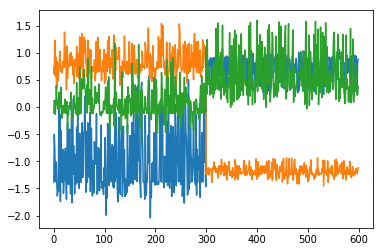

In [29]:
eta = samples['eta2']
print(eta.shape)
plt.plot(eta[:, 0])
plt.plot(eta[:, 1])
plt.plot(eta[:, 2])

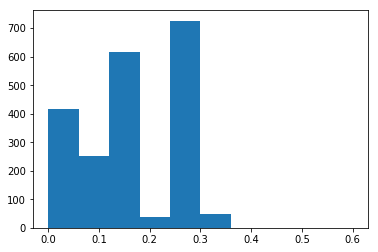

In [58]:
plt.hist(sigma, range=[0, 0.6]);

In [62]:
sigma_mean = np.mean(samples['sigma'])
sigma_median = np.nanmedian(samples['sigma'])

print(sigma_mean)
print(sigma_median)

0.7080905589358755
0.2575391868400646


(2800, 20)


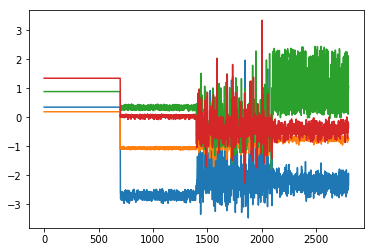

In [64]:
eta_fitc = samples['eta2']
print(eta_fitc.shape)
plt.plot(eta_fitc[:, 0])
plt.plot(eta_fitc[:, 1])
plt.plot(eta_fitc[:, 2])
plt.plot(eta_fitc[:, 5])